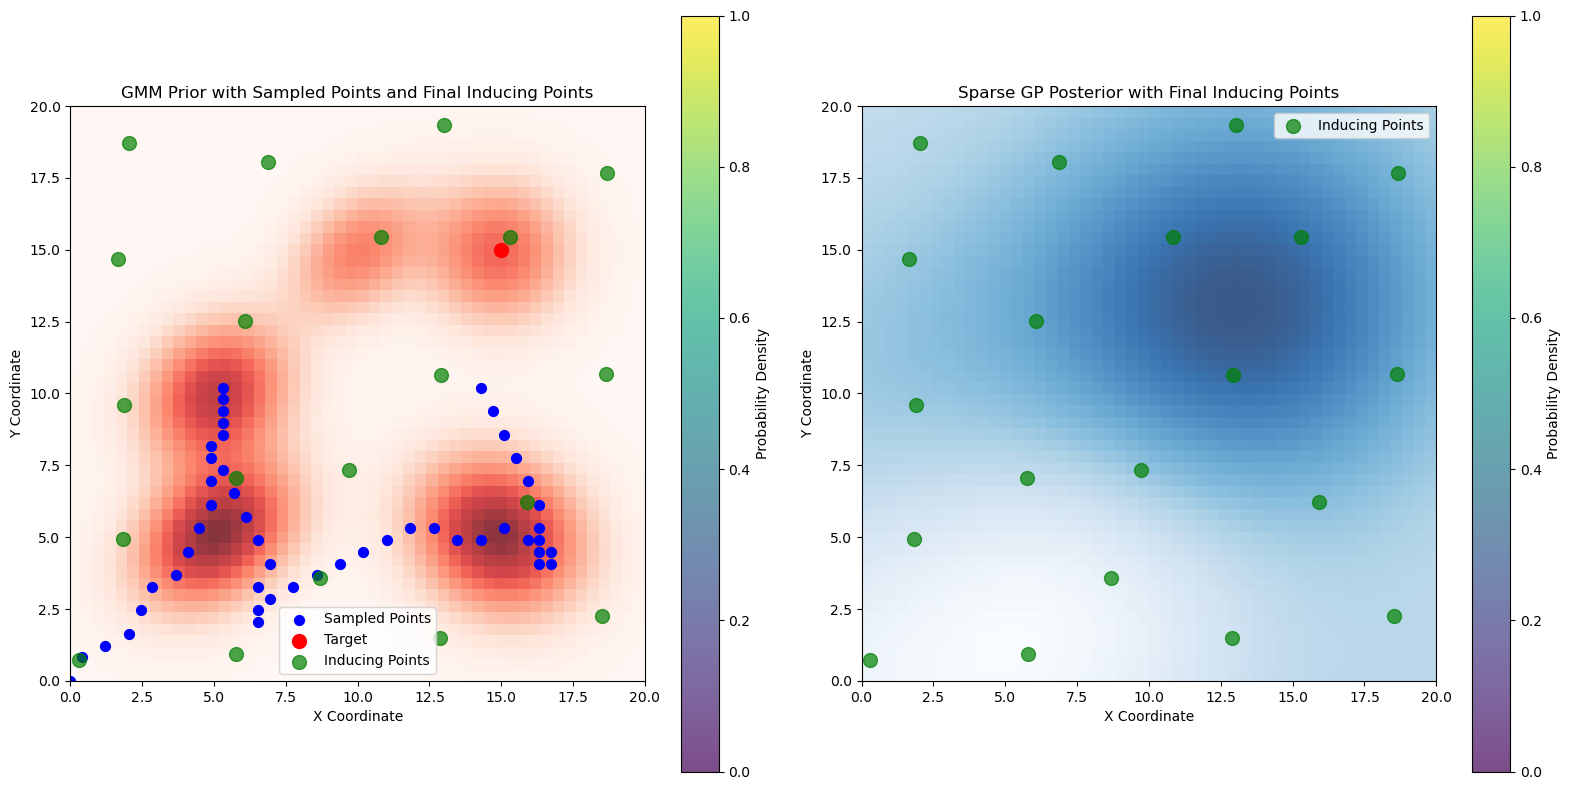

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import GPy
import os

# 创建保存 GIF 帧的文件夹
os.makedirs("frames", exist_ok=True)

# 定义目标位置
target_position = np.array([15, 15])
target_radius = 5.0  # 目标点感知范围

# 定义 GMM 先验
means = np.array([[5, 10], [15, 5], [10, 15], [5, 5], [15, 15]])
covariances = [
    [[3, 0.5], [0.5, 3]],
    [[4, -0.5], [-0.5, 3.5]],
    [[2.5, 0.8], [0.8, 2.5]],
    [[3.5, 1], [1, 3]],
    [[3, 0], [0, 3]]
]
weights = [0.2, 0.3, 0.1, 0.25, 0.15]

# 构建高分辨率网格
x_grid, y_grid = np.meshgrid(np.linspace(0, 20, 50), np.linspace(0, 20, 50))
grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

# 计算 GMM 的概率密度
gmm_probs = np.zeros(grid_points.shape[0])
for mean, cov, weight in zip(means, covariances, weights):
    rv = multivariate_normal(mean, cov)
    gmm_probs += weight * rv.pdf(grid_points)

# 初始化动态观测点和观测值
observed_points = []  # 累积的观测点
observed_values = []  # 累积的观测值

# 初始化稀疏 GP 模型
kernel = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
num_inducing = 20  # 设置诱导点数量
inducing_points = grid_points[np.random.choice(grid_points.shape[0], num_inducing, replace=False)]
sparse_gp_model = GPy.models.SparseGPRegression(grid_points, gmm_probs[:, None], kernel, Z=inducing_points)
sparse_gp_model.optimize()

# 初始化探索
current_point = np.array([0, 0])  # 起点
max_steps = 50                     # 限制探索步数
max_distance = 1.0                 # 每步最大移动距离
kappa = 1.0                        # UCB 中的探索权重

# 目标值感知函数
def sense_target(current_point, target_position, target_radius):
    # 如果目标在感知范围内，返回 1，否则返回 0
    distance_to_target = np.linalg.norm(current_point - target_position)
    return 1 if distance_to_target <= target_radius else -0.1

# UCB 策略选择下一点
def ucb_strategy(grid_points, sparse_gp_model, kappa, current_point, max_distance):
    mu, var = sparse_gp_model.predict(grid_points)
    sigma = np.sqrt(var)
    ucb = mu.flatten() + kappa * sigma.flatten()

    # 限制到可行范围内，并排除当前点
    distances = np.linalg.norm(grid_points - current_point, axis=1)
    candidate_points = grid_points[(distances <= max_distance) & (distances > 1e-3)]  # 排除当前点
    candidate_ucb = ucb[(distances <= max_distance) & (distances > 1e-3)]

    # 如果没有候选点，直接返回当前点
    if len(candidate_points) == 0:
        return current_point

    # 选择最大 UCB 的点
    next_point_idx = np.argmax(candidate_ucb)
    return candidate_points[next_point_idx]

# 探索循环
inducing_points_history = []  # 用于记录每次优化后的诱导点位置
for step in range(max_steps):
    # 记录当前点并更新观测值
    observed_points.append(current_point)
    observed_values.append(sense_target(current_point, target_position, target_radius))

    # 组合先验点和新增观测点
    updated_points = np.vstack([grid_points, observed_points])  # GMM 网格点 + 观测点
    updated_values = np.hstack([gmm_probs, observed_values])    # GMM 值 + 观测值

    # 更新稀疏 GP 模型
    sparse_gp_model.set_XY(updated_points, updated_values[:, None])
    sparse_gp_model.optimize()

    # 记录诱导点位置
    inducing_points_history.append(sparse_gp_model.Z.values.copy())

    # 选择下一点
    current_point = ucb_strategy(grid_points, sparse_gp_model, kappa, current_point, max_distance)

# 可视化最后的结果
plt.figure(figsize=(16, 8))

# 子图 1: GMM 先验分布
plt.subplot(1, 2, 1)
plt.imshow(gmm_probs.reshape(x_grid.shape), extent=(0, 20, 0, 20), origin='lower', cmap='Reds', alpha=0.8)
plt.scatter(*np.array(observed_points).T, c='blue', s=50, label="Sampled Points")  # 采样点
plt.scatter(*target_position, c='red', s=100, label="Target")
plt.scatter(*sparse_gp_model.Z.values.T, c='green', s=100, label="Inducing Points", alpha=0.7)  # 诱导点
plt.title("GMM Prior with Sampled Points and Final Inducing Points")
plt.colorbar(label="Probability Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

# 子图 2: GP 动态预测分布
mu, _ = sparse_gp_model.predict(grid_points)
plt.subplot(1, 2, 2)
plt.imshow(mu.reshape(x_grid.shape), extent=(0, 20, 0, 20), origin='lower', cmap='Blues', alpha=0.8)
plt.scatter(*sparse_gp_model.Z.values.T, c='green', s=100, label="Inducing Points", alpha=0.7)  # 诱导点
plt.title(f"Sparse GP Posterior with Final Inducing Points")
plt.colorbar(label="Probability Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

plt.tight_layout()
plt.savefig("frames/final_frame.png")
plt.show()


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
# 使用 patches.Rectangle 替换 scatter
from matplotlib.patches import Rectangle

# 创建文件夹用于存储可视化结果
output_folder = "uuv_visualizations"
os.makedirs(output_folder, exist_ok=True)

# 参数设置
np.random.seed(42)
num_interest_points = 10  # 兴趣点数量
interest_points = np.random.rand(num_interest_points, 2) * 100  # 兴趣点位置
uuv_positions = np.array([[0, 0], [0, 0], [0, 0]], dtype=float)  # 初始位置改为float类型
visited_points = set()  # 已访问的兴趣点
auctioned_points = set()  # 已拍卖的兴趣点
uuv_targets = [None, None, None]  # 每个UUV的目标兴趣点
uuv_status = [False, False, False]  # 是否忙碌（True: 忙碌, False: 空闲）
speed = 5  # 每轮UUV移动的距离
round_number = 0

# 可视化函数
def save_visualization(interest_points, uuv_positions, visited_points, round_number, output_folder):
    # plt.figure(figsize=(10, 8))
    fig, ax = plt.subplots(figsize=(10, 8))
    # 兴趣点
    for i, (x, y) in enumerate(interest_points):
        color = 'green' if i in visited_points else 'red'  # 已访问的点用绿色，未访问的点用红色
        plt.scatter(x, y, color=color, label=f'Interest Point {i}' if i not in visited_points else None, s=100)
        plt.text(x + 1, y, f'P{i}', fontsize=9)
    
    # UUV
    colors = ['blue', 'orange', 'purple']
    # 示例代码
    for i, (x, y) in enumerate(uuv_positions):
        rect = Rectangle((x - 2.5, y - 2.5), 5, 5, color=colors[i], alpha=0.8)  # 矩形的左下角位置和尺寸
        ax.add_patch(rect)  # 添加矩形到图中
        ax.text(x + 2, y, f'UUV{i}', fontsize=8)  # 添加文本标签
    # for i, (x, y) in enumerate(uuv_positions):
    #     plt.scatter(x, y, color=colors[i], label=f'UUV {i}')
    #     plt.text(x + 1, y, f'UUV{i}', fontsize=9)
    
    plt.legend(loc='upper right')
    plt.title(f'UUV Coverage Simulation - Round {round_number}')
    plt.xlim(-10, 110)
    plt.ylim(-10, 110)
    plt.grid()
    plt.savefig(os.path.join(output_folder, f"round_{round_number:03d}.png"))
    plt.close()

# 最近邻算法求解 TSP
def solve_tsp_nearest_neighbor(points):
    n = len(points)
    visited = [False] * n
    order = [0]  # 从第一个点开始
    visited[0] = True
    
    for _ in range(n - 1):
        last = order[-1]
        nearest = None
        nearest_distance = float('inf')
        for i in range(n):
            if not visited[i]:
                distance = euclidean(points[last], points[i])
                if distance < nearest_distance:
                    nearest = i
                    nearest_distance = distance
        order.append(nearest)
        visited[nearest] = True
    
    return order

# 优化兴趣点顺序
optimal_order = solve_tsp_nearest_neighbor(interest_points)
interest_points = interest_points[np.array(optimal_order)]  # 按最优顺序重排兴趣点

# 主函数逻辑
while len(visited_points) < len(interest_points):
    round_number += 1
    print(f"\nRound {round_number}:")
    
    # 检查是否有空闲的UUV可以进行新拍卖
    for uuv_id in range(1, 3):  # 只有UUV 1 和 UUV 2 参与拍卖
        if not uuv_status[uuv_id] and uuv_targets[uuv_id] is None:  # UUV空闲并且无任务
            unauctioned_points = [i for i in range(len(interest_points)) if i not in auctioned_points]
            if unauctioned_points:
                current_task = unauctioned_points[0]  # 按优化顺序选择未拍卖的兴趣点
                print(f"Interest Point {current_task} is up for auction.")
                auctioned_points.add(current_task)  # 标记为已拍卖

                # UUV 1 和 UUV 2 竞标
                bids = {}
                for j in range(1, 3):  # UUV 1 和 UUV 2 参与竞标
                    if not uuv_status[j] and uuv_targets[j] is None:  # 空闲时才竞标
                        distance = euclidean(uuv_positions[j], interest_points[current_task])
                        bids[j] = distance
                
                if bids:
                    # 分配任务给最近的UUV
                    assigned_uuv = min(bids, key=bids.get)
                    uuv_status[assigned_uuv] = True  # 标记为忙碌
                    uuv_targets[assigned_uuv] = current_task
                    print(f"UUV {assigned_uuv} won the bid for Interest Point {current_task}.")
    
    # 更新UUV位置
    for i in range(1, 3):  # 只有UUV 1 和 UUV 2 移动
        if uuv_targets[i] is not None:  # 如果有目标
            target_pos = interest_points[uuv_targets[i]]
            current_pos = uuv_positions[i]
            distance_to_target = euclidean(current_pos, target_pos)
            
            # 移动UUV
            if distance_to_target <= speed:  # 如果能到达目标点
                uuv_positions[i] = target_pos  # 到达目标点
                visited_points.add(uuv_targets[i])  # 标记点已访问
                print(f"UUV {i} reached Interest Point {uuv_targets[i]}.")
                uuv_targets[i] = None  # 清空目标
                uuv_status[i] = False  # 标记为空闲
            else:  # 没有到达目标点，则按方向移动
                direction = (target_pos - current_pos) / distance_to_target
                uuv_positions[i] += direction * speed
    
    # 保存当前轮次的可视化
    save_visualization(interest_points, uuv_positions, visited_points, round_number, output_folder)

print(f"Simulation completed. Visualizations are saved in the folder: {output_folder}")



Round 1:
Interest Point 0 is up for auction.
UUV 1 won the bid for Interest Point 0.
Interest Point 1 is up for auction.
UUV 2 won the bid for Interest Point 1.

Round 2:

Round 3:

Round 4:

Round 5:

Round 6:

Round 7:

Round 8:

Round 9:

Round 10:

Round 11:

Round 12:

Round 13:

Round 14:

Round 15:

Round 16:

Round 17:

Round 18:
UUV 2 reached Interest Point 1.

Round 19:
Interest Point 2 is up for auction.
UUV 2 won the bid for Interest Point 2.

Round 20:

Round 21:
UUV 1 reached Interest Point 0.
UUV 2 reached Interest Point 2.

Round 22:
Interest Point 3 is up for auction.
UUV 1 won the bid for Interest Point 3.
Interest Point 4 is up for auction.
UUV 2 won the bid for Interest Point 4.

Round 23:

Round 24:

Round 25:

Round 26:

Round 27:

Round 28:

Round 29:

Round 30:
UUV 1 reached Interest Point 3.

Round 31:
Interest Point 5 is up for auction.
UUV 1 won the bid for Interest Point 5.

Round 32:

Round 33:

Round 34:

Round 35:

Round 36:

Round 37:
UUV 2 reached Inte

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Round 63:
UUV 1 reached Interest Point 9.
Simulation completed. Visualizations are saved in the folder: uuv_visualizations


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import os
import imageio

# 动画函数
def create_animation_from_images(output_folder, gif_filename="uuv_simulation_gmm.gif"):
    # 获取所有图片文件并按顺序排序
    image_files = sorted([os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".png")])
    
    # 用 imageio 生成 GIF
    images = []
    for file in image_files:
        try:
            # 尝试读取图片
            images.append(imageio.imread(file))
        except Exception as e:
            print(f"Skipped invalid image file: {file}. Error: {e}")
    
    if not images:
        print("No valid images found. GIF generation aborted.")
        return
    
    # 保存 GIF
    imageio.mimsave(gif_filename, images, fps=5)  # 每秒2帧
    print(f"GIF animation saved as {gif_filename}")

# 调用动画生成函数
create_animation_from_images(output_folder, gif_filename="uuv_simulation.gif")


GIF animation saved as uuv_simulation.gif


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from matplotlib.patches import Rectangle

# 创建文件夹用于存储可视化结果
output_folder = "uuv_visualizations"
os.makedirs(output_folder, exist_ok=True)

# 参数设置
np.random.seed(42)
num_interest_points = 10  # 兴趣点数量
interest_points = np.random.rand(num_interest_points, 2) * 100  # 兴趣点位置
uuv_positions = np.array([[0, 0], [0, 0], [0, 0]], dtype=float)  # 初始位置改为float类型
visited_points = set()  # 已访问的兴趣点
auctioned_points = set()  # 已拍卖的兴趣点
uuv_targets = [None, None, None]  # 每个UUV的目标兴趣点
uuv_status = [False, False, False]  # 是否忙碌（True: 忙碌, False: 空闲）
speed = 5  # 每轮UUV移动的距离
round_number = 0

# 可视化函数
def save_visualization(interest_points, uuv_positions, visited_points, round_number, output_folder):
    fig, ax = plt.subplots(figsize=(10, 8))
    # 兴趣点
    for i, (x, y) in enumerate(interest_points):
        color = 'green' if i in visited_points else 'red'  # 已访问的点用绿色，未访问的点用红色
        ax.scatter(x, y, color=color, label=f'Interest Point {i}' if i not in visited_points else None, s=100)
        ax.text(x + 1, y, f'P{i}', fontsize=9)

    # UUV
    colors = ['blue', 'orange', 'purple']
    for i, (x, y) in enumerate(uuv_positions):
        rect = Rectangle((x - 2.5, y - 2.5), 5, 5, color=colors[i], alpha=0.8)  # 矩形的左下角位置和尺寸
        ax.add_patch(rect)  # 添加矩形到图中
        ax.text(x + 2, y, f'UUV{i}', fontsize=8)  # 添加文本标签

    ax.legend(loc='upper right')
    ax.set_title(f'UUV Coverage Simulation - Round {round_number}')
    ax.set_xlim(-10, 110)
    ax.set_ylim(-10, 110)
    ax.grid()
    plt.savefig(os.path.join(output_folder, f"round_{round_number:03d}.png"))
    plt.close()

# 蚁群算法求解 TSP
def solve_tsp_ant_colony(points, uuv_positions, num_ants=10, num_iterations=100, alpha=1, beta=2, evaporation_rate=0.5):
    num_points = len(points)
    pheromone = np.ones((num_points, num_points))  # 信息素矩阵
    distance_matrix = np.array([[euclidean(points[i], points[j]) for j in range(num_points)] for i in range(num_points)])
    visibility = 1 / (distance_matrix + 1e-10)  # 能见度矩阵，避免除零

    best_path = None
    best_distance = float('inf')

    for iteration in range(num_iterations):
        paths = []
        path_distances = []

        for ant in range(num_ants):
            current_pos = uuv_positions[np.random.randint(len(uuv_positions))]  # 随机选择UUV的初始位置
            path = [np.argmin([euclidean(current_pos, p) for p in points])]  # 从最近的点开始
            visited = set(path)

            for _ in range(num_points - 1):
                current = path[-1]
                probabilities = []
                for next_point in range(num_points):
                    if next_point not in visited:
                        prob = (pheromone[current, next_point] ** alpha) * (visibility[current, next_point] ** beta)
                        probabilities.append(prob)
                    else:
                        probabilities.append(0)

                probabilities = np.array(probabilities) / np.sum(probabilities)
                next_point = np.random.choice(range(num_points), p=probabilities)
                path.append(next_point)
                visited.add(next_point)

            paths.append(path)
            path_distance = sum(distance_matrix[path[i], path[i + 1]] for i in range(num_points - 1))
            path_distance += distance_matrix[path[-1], path[0]]  # 回到起点
            path_distances.append(path_distance)

            if path_distance < best_distance:
                best_path = path
                best_distance = path_distance

        # 更新信息素
        pheromone *= (1 - evaporation_rate)
        for path, distance in zip(paths, path_distances):
            for i in range(num_points - 1):
                pheromone[path[i], path[i + 1]] += 1 / distance
            pheromone[path[-1], path[0]] += 1 / distance

    return best_path

# 主函数逻辑
while len(visited_points) < len(interest_points):
    round_number += 1
    print(f"\nRound {round_number}:")

    # 更新未访问点的最优顺序
    remaining_indices = [i for i in range(len(interest_points)) if i not in visited_points]
    if remaining_indices:
        remaining_points = interest_points[remaining_indices]
        optimal_order = solve_tsp_ant_colony(remaining_points, uuv_positions)

        # 重排剩余点并保持索引映射
        reordered_indices = [remaining_indices[i] for i in optimal_order]
        reordered_points = interest_points[reordered_indices]
        interest_points = np.array(reordered_points)

        # 更新拍卖和目标索引
        remap = {old_idx: new_idx for new_idx, old_idx in enumerate(reordered_indices)}
        auctioned_points = {remap[idx] for idx in auctioned_points if idx in remap}
        visited_points = {remap[idx] for idx in visited_points if idx in remap}
        uuv_targets = [remap[idx] if idx in remap else None for idx in uuv_targets]

    # 检查是否有空闲的UUV可以进行新拍卖
    for uuv_id in range(1, 3):  # 只有UUV 1 和 UUV 2 参与拍卖
        if not uuv_status[uuv_id] and uuv_targets[uuv_id] is None:  # UUV空闲并且无任务
            unauctioned_points = [i for i in range(len(interest_points)) if i not in auctioned_points]
            if unauctioned_points:
                current_task = unauctioned_points[0]  # 按优化顺序选择未拍卖的兴趣点
                print(f"Interest Point {current_task} is up for auction.")
                auctioned_points.add(current_task)  # 标记为已拍卖

                # UUV 1 和 UUV 2 竞标
                bids = {}
                for j in range(1, 3):  # UUV 1 和 UUV 2 参与竞标
                    if not uuv_status[j] and uuv_targets[j] is None:  # 空闲时才竞标
                        distance = euclidean(uuv_positions[j], interest_points[current_task])
                        bids[j] = distance

                if bids:
                    # 分配任务给最近的UUV
                    assigned_uuv = min(bids, key=bids.get)
                    uuv_status[assigned_uuv] = True  # 标记为忙碌
                    uuv_targets[assigned_uuv] = current_task
                    print(f"UUV {assigned_uuv} won the bid for Interest Point {current_task}.")

    # 更新UUV位置
    for i in range(1, 3):  # 只有UUV 1 和 UUV 2 移动
        if uuv_targets[i] is not None:  # 如果有目标
            target_idx = uuv_targets[i]
            if target_idx < len(interest_points):  # 确保索引有效
                target_pos = interest_points[target_idx]
                current_pos = uuv_positions[i]
                distance_to_target = euclidean(current_pos, target_pos)

                # 移动UUV
                if distance_to_target <= speed:  # 如果能到达目标点
                    uuv_positions[i] = target_pos  # 到达目标点
                    visited_points.add(uuv_targets[i])  # 标记点已访问
                    print(f"UUV {i} reached Interest Point {uuv_targets[i]}.")
                    uuv_targets[i] = None  # 清空目标
                    uuv_status[i] = False  # 标记为空闲
                else:  # 没有到达目标点，则按方向移动
                    direction = (target_pos - current_pos) / distance_to_target
                    uuv_positions[i] += direction * speed
            else:
                print(f"Invalid target index {target_idx} for UUV {i}. Skipping.")

    # 保存当前轮次的可视化
    save_visualization(interest_points, uuv_positions, visited_points, round_number, output_folder)

print(f"Simulation completed. Visualizations are saved in the folder: {output_folder}")



Round 1:
Interest Point 0 is up for auction.
UUV 1 won the bid for Interest Point 0.
Interest Point 1 is up for auction.
UUV 2 won the bid for Interest Point 1.

Round 2:

Round 3:

Round 4:

Round 5:
UUV 1 reached Interest Point 0.

Round 6:
Interest Point 1 is up for auction.
UUV 1 won the bid for Interest Point 1.
UUV 2 reached Interest Point 0.

Round 7:
Interest Point 1 is up for auction.
UUV 2 won the bid for Interest Point 1.

Round 8:

Round 9:

Round 10:

Round 11:

Round 12:
UUV 1 reached Interest Point 1.

Round 13:
Interest Point 1 is up for auction.
UUV 1 won the bid for Interest Point 1.

Round 14:
UUV 2 reached Interest Point 0.

Round 15:
Interest Point 0 is up for auction.
UUV 2 won the bid for Interest Point 0.

Round 16:

Round 17:

Round 18:

Round 19:

Round 20:

Round 21:
UUV 2 reached Interest Point 0.

Round 22:
Interest Point 0 is up for auction.
UUV 2 won the bid for Interest Point 0.

Round 23:

Round 24:

Round 25:
UUV 2 reached Interest Point 0.

Round 26:

 C:\Users\52324\AppData\Local\Temp\ipykernel_29692\1927787309.py:95: RuntimeWarning:divide by zero encountered in double_scalars



Round 35:

Round 36:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Round 37:
UUV 1 reached Interest Point 0.
Simulation completed. Visualizations are saved in the folder: uuv_visualizations


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import GPy

# 创建保存文件夹
output_folder = "uuv_visualizations_sparse_gp0"
os.makedirs(output_folder, exist_ok=True)

# 初始化 GMM 先验分布
means = np.array([[5, 10], [15, 5], [10, 15], [5, 5], [15, 15]])
covariances = [
    [[3, 0.5], [0.5, 3]],
    [[4, -0.5], [-0.5, 3.5]],
    [[2.5, 0.8], [0.8, 2.5]],
    [[3.5, 1], [1, 3]],
    [[3, 0], [0, 3]]
]
weights = [0.2, 0.3, 0.1, 0.25, 0.15]

# 创建网格和计算概率密度
x_grid, y_grid = np.meshgrid(np.linspace(0, 20, 50), np.linspace(0, 20, 50))
grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

gmm_probs = np.zeros(grid_points.shape[0])
for mean, cov, weight in zip(means, covariances, weights):
    rv = multivariate_normal(mean, cov)
    gmm_probs += weight * rv.pdf(grid_points)

# 初始化稀疏 GP
kernel = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
num_inducing = 20
inducing_points = grid_points[np.random.choice(grid_points.shape[0], num_inducing, replace=False)]
sparse_gp_model = GPy.models.SparseGPRegression(grid_points, gmm_probs[:, None], kernel, Z=inducing_points)
sparse_gp_model.optimize()

# 初始化 UUV 和其他变量
num_uuv = 2
uuv_positions = np.zeros((num_uuv, 2))
uuv_status = [False] * num_uuv
uuv_targets = [None] * num_uuv
observed_points = []
observed_values = []
assigned_targets = set()  # 已分配目标点集合

# 参数设置
max_steps = 50
max_distance = 2.0  # UUV 每步最大移动距离
kappa = 1.0  # UCB 中的探索权重
target_radius = 5.0
target_position = np.array([15, 15])  # 目标实际位置
ucb_horizon = 5  # UCB 搜索路径的步长

def sense_target(current_point, target_position, target_radius):
    distance = np.linalg.norm(current_point - target_position)
    return 1 if distance <= target_radius else -0.1

# UCB 策略选择下一目标点
def select_next_target(grid_points, sparse_gp_model, current_point, max_distance, kappa, assigned_targets, exclude_points):
    mu, var = sparse_gp_model.predict(grid_points)
    sigma = np.sqrt(var)
    ucb = mu.flatten() + kappa * sigma.flatten()

    # 筛选候选点
    distances = np.linalg.norm(grid_points - current_point, axis=1)
    candidates = (distances <= max_distance) & (distances > 1e-3)
    candidate_points = grid_points[candidates]
    candidate_ucb = ucb[candidates]

    # 排除已分配目标点和排除点
    valid_candidates = [point for point in candidate_points if tuple(point) not in assigned_targets and tuple(point) not in exclude_points]
    if not valid_candidates:
        return None

    valid_ucb = [ucb for point, ucb in zip(candidate_points, candidate_ucb) if tuple(point) not in assigned_targets and tuple(point) not in exclude_points]
    return valid_candidates[np.argmax(valid_ucb)]

# 主循环
found_target = False
for step in range(max_steps):
    if found_target:
        print("Target found, stopping exploration.")
        break

    print(f"\nRound {step + 1}")

    exclude_points = set()  # 用于防止 UUV 重复选择

    # 每个空闲 UUV 竞标选择目标点
    for i in range(num_uuv):
        if not uuv_status[i]:  # 如果 UUV 空闲
            target = select_next_target(grid_points, sparse_gp_model, uuv_positions[i], max_distance, kappa, assigned_targets, exclude_points)
            if target is not None:
                uuv_targets[i] = target
                uuv_status[i] = True
                assigned_targets.add(tuple(target))  # 标记目标点为已分配
                exclude_points.add(tuple(target))  # 防止其他 UUV 选择相同目标
                print(f"UUV {i} targets point: {target}")

    # 更新 UUV 位置并处理到达目标
    for i in range(num_uuv):
        if uuv_targets[i] is not None:
            target = uuv_targets[i]
            distance = np.linalg.norm(uuv_positions[i] - target)
            if distance <= max_distance:  # 如果目标点在移动范围内
                uuv_positions[i] = target
                observed_value = sense_target(target, target_position, target_radius)
                observed_points.append(target)
                observed_values.append(observed_value)

                # 如果找到目标，停止搜索
                if observed_value == 1:
                    found_target = True
                    print(f"UUV {i} found the target at {target}.")
                    break

                # 更新 GP 后验分布
                updated_points = np.vstack([grid_points, observed_points])
                updated_values = np.hstack([gmm_probs, observed_values])
                sparse_gp_model.set_XY(updated_points, updated_values[:, None])
                sparse_gp_model.optimize()

                uuv_targets[i] = None
                uuv_status[i] = False  # 标记为空闲
                print(f"UUV {i} reached point: {target} with observation value: {observed_value}")
            else:
                direction = (target - uuv_positions[i]) / distance
                uuv_positions[i] += direction * max_distance

    # 可视化
    plt.figure(figsize=(10, 8))
    mu, _ = sparse_gp_model.predict(grid_points)
    plt.imshow(mu.reshape(x_grid.shape), extent=(0, 20, 0, 20), origin='lower', cmap='Reds', alpha=0.8)
    plt.scatter(uuv_positions[:, 0], uuv_positions[:, 1], c='blue', s=100, label='UUVs')
    if observed_points:
        obs_points = np.array(observed_points)
        plt.scatter(obs_points[:, 0], obs_points[:, 1], c='green', s=50, label='Observed Points')
    plt.scatter(target_position[0], target_position[1], marker='*', c='yellow', s=200, label='Target')
    plt.title(f"Round {step + 1}")
    plt.legend()
    plt.savefig(os.path.join(output_folder, f"round_{step + 1:03d}.png"))
    plt.close()

print(f"Simulation completed. Visualizations saved in {output_folder}.")



Round 1
UUV 0 targets point: [1.2244898 1.2244898]
UUV 1 targets point: [0.81632653 1.63265306]
UUV 0 reached point: [1.2244898 1.2244898] with observation value: -0.1
UUV 1 reached point: [0.81632653 1.63265306] with observation value: -0.1

Round 2
UUV 0 targets point: [2.44897959 2.44897959]
UUV 1 targets point: [2.04081633 2.85714286]
UUV 0 reached point: [2.44897959 2.44897959] with observation value: -0.1
UUV 1 reached point: [2.04081633 2.85714286] with observation value: -0.1

Round 3
UUV 0 targets point: [3.67346939 3.67346939]
UUV 1 targets point: [3.26530612 4.08163265]
UUV 0 reached point: [3.67346939 3.67346939] with observation value: -0.1
UUV 1 reached point: [3.26530612 4.08163265] with observation value: -0.1

Round 4
UUV 0 targets point: [4.48979592 5.30612245]
UUV 1 targets point: [4.08163265 5.71428571]
UUV 0 reached point: [4.48979592 5.30612245] with observation value: -0.1
UUV 1 reached point: [4.08163265 5.71428571] with observation value: -0.1

Round 5
UUV 0 t

In [ ]:
import os
from PIL import Image

# 设置输入文件夹和输出 GIF 文件名
input_folder = "uuv_visualizations_sparse_gp"
output_gif = "output_animation_high_res.gif"

# 获取 PNG 文件，按文件名排序
image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".png")])

# 确保文件夹中有图片
if not image_files:
    print("No PNG images found.")
else:
    # 读取图片
    images = [Image.open(os.path.join(input_folder, f)).convert("RGB") for f in image_files]

    # 统一图片大小（防止不同尺寸图片导致失真）
    width, height = images[0].size  # 读取第一张图片的尺寸
    images = [img.resize((width, height), Image.LANCZOS) for img in images]

    # 量化颜色以减少GIF损失
    images = [img.quantize(colors=256) for img in images]

    # 保存 GIF，设置更高质量
    images[0].save(
        output_gif,
        save_all=True,
        append_images=images[1:],
        duration=500,  # 控制帧速率（毫秒）
        loop=0,  # 无限循环
        optimize=False  # 关闭默认优化，避免质量损失
    )

    print(f"High-resolution GIF saved as {output_gif}")


High-resolution GIF saved as output_animation_high_res.gif


: 